# MNIST-SVM-PCA

The following script executes a program for digit recognition on the mnist database using Support Vector Machines (SVM) and Principal Component Analysis (PCA). 

In [1]:
### Packages
from datetime import datetime
import time
import os

import matplotlib.pyplot as plt
%matplotlib inline

from keras.datasets import mnist

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

import config

### Configurations
# Training-Size
num_train = config.num_train                   # 60000 for full data set 
num_test  = config.num_test                    # 10000 for full data set

In [2]:
# Simple function to log information
path = os.getcwd()+"/log"
logDir = os.path.exists(path)
if not logDir:
    os.makedirs(path)

training_results = path+"/svm-pca-training-log.txt"
def log_training_results(*s):
    with open(training_results, 'a') as f:
        for arg in s:
            print(arg, file=f)
            print(arg)

hyperparameter_search_log = path+"/svm-pca-hyperparameter-tuning-log.txt"
def log_hyperparameter_search(*s):
    with open(hyperparameter_search_log, 'a') as f:
        for arg in s:
            print(arg, file=f)
            print(arg)

print("Generated data will be located in ", training_results, hyperparameter_search_log)
log_training_results("[%s] on (%s, %s) using (Train: %s, Test: %s)" % (datetime.now(), config.os, config.cpu, config.num_train, config.num_test))
if config.hyper_parameter_search:
    log_hyperparameter_search("[%s] on (%s, %s) using (Train: %s, Test: %s)" % (datetime.now(), config.os, config.cpu, config.num_train, config.num_test))


Generated data will be located in  c:\Users\auerth\Desktop\Study\MNIST_Digits_Benchmark\src/log/svm-pca-training-log.txt c:\Users\auerth\Desktop\Study\MNIST_Digits_Benchmark\src/log/svm-pca-hyperparameter-tuning-log.txt
[2022-09-13 11:25:49.872478] on (Windows-10-10.0.19044-SP0, Intel64 Family 6 Model 140 Stepping 1, GenuineIntel) using (Train: 15000, Test: 2500)


In [3]:
# Fetch MNIST-Data from Keras repository
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
# Display (Train) (Test) datasets
print("Shape of training data:\t\t", X_train.shape)
print("Shape of training labels:\t", y_train.shape)
print("Shape of testing data:\t\t", X_test.shape)
print("Shape of testing labels:\t", y_test.shape)

# i.e.: We have 60000 images with a size of 28x28 pixels


Shape of training data:		 (60000, 28, 28)
Shape of training labels:	 (60000,)
Shape of testing data:		 (10000, 28, 28)
Shape of testing labels:	 (10000,)


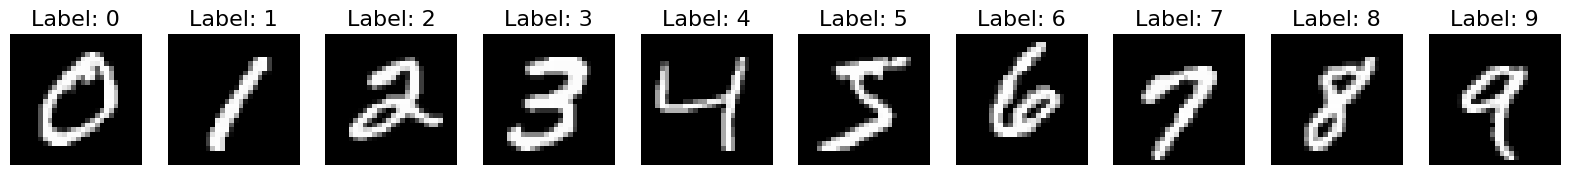

In [5]:
# Visualize some examples
num_classes = 10 # 0 .. 9
f, ax = plt.subplots(1, num_classes, figsize=(20,20))
for i in range(0, num_classes):
  sample = X_train[y_train == i][0]
  ax[i].imshow(sample, cmap='gray')
  ax[i].set_title("Label: {}".format(i), fontsize=16)
  ax[i].axis('off')

# Prepare loaded data

In [6]:
# Reshape the data such that we have access to every pixel of the image
# The reason to access every pixel is that only then we can apply deep learning ideas and can assign color code to every pixel.

train_data = X_train.reshape((X_train.shape[0], 28*28)).astype('float32')
train_label = y_train.astype("float32")

test_data = X_test.reshape((X_test.shape[0], 28*28)).astype('float32')
test_label = y_test.astype("float32")




In [7]:
# We know the RGB color code where different values produce various colors. It is also difficult to remember every color combination. 
# We already know that each pixel has its unique color code and also we know that it has a maximum value of 255. 
# To perform Machine Learning, it is important to convert all the values from 0 to 255 for every pixel to a range of values from 0 to 1.
train_data = train_data / 255
test_data = test_data / 255

In [8]:
# As an optional step, we decrease the training and testing data size, such that the algorithms perform their execution in acceptable time
train_data = train_data[1:num_train,]
train_label = train_label[1:num_train]

test_data = test_data[1:num_test,]
test_label = test_label[1:num_test]

In [9]:
# Display (Train) (Test) datasets

print("Reshaped training data:\t\t", train_data.shape)
print("Reshaped training labels:\t", train_label.shape)
print("Reshaped testing data:\t\t", test_data.shape)
print("Reshaped testing labels:\t", test_label.shape)

# As we can see: We now have X images with 784 pixels in total
# We now operate on this data

Reshaped training data:		 (14999, 784)
Reshaped training labels:	 (14999,)
Reshaped testing data:		 (2499, 784)
Reshaped testing labels:	 (2499,)


# Principal Component Analysis

Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space. The input data is centered but not scaled for each feature before applying the SVD.
It uses the LAPACK implementation of the full SVD or a randomized truncated SVD by the method of Halko et al. 2009, depending on the shape of the input data and the number of components to extract.

For more information, see: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html 

In [10]:
# The default layout of PCA()
# @see https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
pca = PCA(
    n_components=None,                  # Number of components to keep. if n_components is not set all components are kept
    copy=True,                          # If False, data passed to fit are overwritten and running fit(X).transform(X) will not yield the expected results, use fit_transform(X) instead.
    whiten=False,                       # Whitening will remove some information from the transformed signal (the relative variance scales of the components) but can sometime improve the predictive accuracy of the downstream estimators by making their data respect some hard-wired assumptions.
    svd_solver='auto',                  # The solver is selected by a default policy based on X.shape and n_components: if the input data is larger than 500x500 and the number of components to extract is lower than 80% of the smallest dimension of the data, then the more efficient ‘randomized’ method is enabled. Otherwise the exact full SVD is computed and optionally truncated afterwards.
    tol=0.0,                            # Tolerance for singular values computed by svd_solver == ‘arpack’. Must be of range [0.0, infinity).
    iterated_power='auto',              # Number of iterations for the power method computed by svd_solver == ‘randomized’. Must be of range [0, infinity).
    n_oversamples=10,                   # This parameter is only relevant when svd_solver="randomized". It corresponds to the additional number of random vectors to sample the range of X so as to ensure proper conditioning.
    power_iteration_normalizer='auto',  # Power iteration normalizer for randomized SVD solver. Not used by ARPACK. See randomized_svd for more details.
    random_state=None                   # Used when the ‘arpack’ or ‘randomized’ solvers are used. Pass an int for reproducible results across multiple function calls. 
)

In [11]:
# Fitting the PCA algorithm with the datasets
pca = PCA().fit(train_data)

In [12]:
# Reshaping the data based on the PCA
pca_train_data = pca.transform(train_data)
pca_test_data = pca.transform(test_data)

In [13]:
# Display (Train) (Test) datasets

print("Reshaped training data:\t\t", pca_train_data.shape)
print("Reshaped training labels:\t", train_label.shape)
print("Reshaped testing data:\t\t", pca_test_data.shape)
print("Reshaped testing labels:\t", test_label.shape)

# As we can see: We now have X images with 784 pixels in total
# We now operate on this data

Reshaped training data:		 (14999, 784)
Reshaped training labels:	 (14999,)
Reshaped testing data:		 (2499, 784)
Reshaped testing labels:	 (2499,)


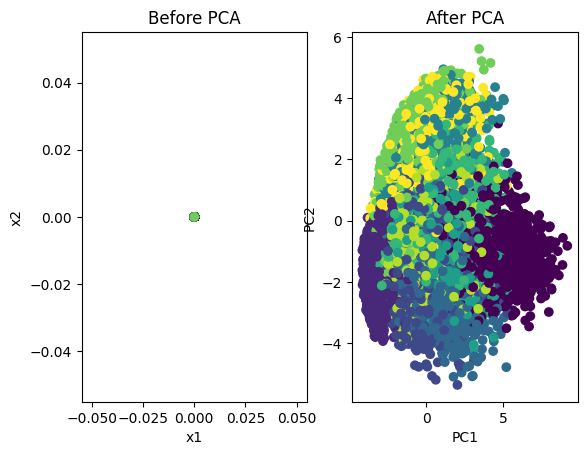

In [14]:
fig, axes = plt.subplots(1,2)
axes[0].scatter(train_data[:,0], train_data[:,1], c=train_label)
axes[0].set_xlabel('x1')
axes[0].set_ylabel('x2')
axes[0].set_title('Before PCA')

axes[1].scatter(pca_train_data[:,0], pca_train_data[:,1], c=train_label)
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title('After PCA')

plt.show()

In [15]:
print(pca.explained_variance_ratio_)

[1.00639261e-01 7.16994181e-02 6.43307865e-02 5.43829799e-02
 4.74458784e-02 4.38812971e-02 3.28165777e-02 2.93203071e-02
 2.84169633e-02 2.31378637e-02 2.10279450e-02 2.05555670e-02
 1.69872902e-02 1.66534763e-02 1.59191340e-02 1.52918687e-02
 1.28840413e-02 1.24956248e-02 1.17824608e-02 1.12236235e-02
 1.03897527e-02 1.00716930e-02 9.47870221e-03 9.13114101e-03
 8.62319488e-03 8.27683602e-03 8.03241041e-03 7.78844720e-03
 7.25765619e-03 6.78205397e-03 6.49985904e-03 6.26852643e-03
 5.95121039e-03 5.79524925e-03 5.52303717e-03 5.22818509e-03
 4.95102815e-03 4.79990058e-03 4.75797802e-03 4.68029734e-03
 4.50354954e-03 4.20591980e-03 4.09748871e-03 3.95421218e-03
 3.75765911e-03 3.67698330e-03 3.54432291e-03 3.38001689e-03
 3.30816954e-03 3.19982111e-03 3.12013924e-03 3.09744454e-03
 2.88221147e-03 2.81799119e-03 2.80453055e-03 2.64468673e-03
 2.59129005e-03 2.50704377e-03 2.47731572e-03 2.41997978e-03
 2.33647297e-03 2.32443889e-03 2.24996801e-03 2.18445365e-03
 2.07488402e-03 2.043377

# Support Vector Machines

Support vector machines (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection. We use the SVM-package supplied by SKLearn.

For more information, see: https://scikit-learn.org/stable/modules/svm.html

In [16]:
# The default layout of svm.svc() 
# @see https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
svm = SVC(
    C=1.0,                          # Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.
    kernel='linear',                # Specifies the kernel type to be used in the algorithm. 
    degree=3,                       # Degree of the polynomial kernel function (‘poly’). Ignored by all other kernels.
    gamma='scale',                  # Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
    coef0=0.0,                      # Independent term in kernel function. It is only significant in ‘poly’ and ‘sigmoid’.
    shrinking=True,                 # Whether to use the shrinking heuristic. 
    probability=False,              # Whether to enable probability estimates. 
    tol=0.001,                      # Tolerance for stopping criterion.
    cache_size=200,                 # Specify the size of the kernel cache (in MB).
    class_weight=None,              # Set the parameter C of class i to class_weight[i]*C for SVC. If not given, all classes are supposed to have weight one. 
    verbose=False,                  # Enable verbose output. Note that this setting takes advantage of a per-process runtime setting in libsvm that, if enabled, may not work properly in a multithreaded context.
    max_iter=-1,                    # Hard limit on iterations within solver, or -1 for no limit.
    decision_function_shape='ovr',  # Whether to return a one-vs-rest (‘ovr’) decision function of shape (n_samples, n_classes) as all other classifiers, or the original one-vs-one (‘ovo’) decision function of libsvm which has shape (n_samples, n_classes * (n_classes - 1) / 2).
    break_ties=False,               # If true, decision_function_shape='ovr', and number of classes > 2, predict will break ties according to the confidence values of decision_function;
    random_state=None               # Controls the pseudo random number generation for shuffling the data for probability estimates.
)

## Linear SVC

In [17]:
# Evalute SVM.SVC with parameters on data below
svm = SVC(kernel='linear')
start_time = time.time()
svm.fit(pca_train_data, train_label)
end_time = time.time() - start_time
log_training_results("Trained new model: {'Kernel':'%s'} in %s seconds" % (svm.get_params()["kernel"], end_time))

start_time = time.time()
score = svm.score(pca_train_data, train_label)
end_time = time.time() - start_time
log_training_results("\t[%s]: mean accuracy on train-data: %s; execution time: %ss" % (svm.get_params()["kernel"], score, end_time))  

start_time = time.time()
score = svm.score(pca_test_data, test_label)
end_time = time.time() - start_time
log_training_results("\t[%s]: mean accuracy on test-data: %s; execution time: %ss" % (svm.get_params()["kernel"], score, end_time))  

Trained new model: {'Kernel':'linear'} in 10.65201997756958 seconds
	[linear]: mean accuracy on train-data: 0.9921328088539236; execution time: 16.034738063812256s
	[linear]: mean accuracy on test-data: 0.8935574229691877; execution time: 2.7030491828918457s


In [18]:
# Hyperparameter search -- Takes up a long time.
if config.hyper_parameter_search:
    svm = SVC()
    parameters = {
            "kernel":["linear"], 
            "C":[1,10,100],            
            "gamma":[0.01,0.005,0.001,0.0005,0.0001],        
            #"shrinking":[True,False],      
            #"probability":[True,False], 
            #"tol":[0.01,0.001,0.0001],
    }
    scores = [
        'accuracy',
        #"precision",    # The precision is intuitively the ability of the classifier not to label as positive a sample that is negative
        #"recall",       # The recall is intuitively the ability of the classifier to find all the positive samples.
        ]
    for score in scores:
        log_hyperparameter_search("\t--- [%s] Running Parameter-Tests [LINEAR-PCA-SVC] ---" % datetime.now())
        log_hyperparameter_search("\tTuning parameters for criteria [%s]" % score)
        # FIXME: Doesn't take accuracy as score for some reason. Refer to line below for accuracy score
        #grid = GridSearchCV(estimator=svm, param_grid=parameters, scoring="%s_macro" % score, verbose=3)
        grid = GridSearchCV(estimator=svm, param_grid=parameters, scoring='accuracy', verbose=3, n_jobs=-1)
        grid.fit(pca_train_data, train_label)

        log_hyperparameter_search("\tBest parameters set found on following development set:")
        log_hyperparameter_search("\t\tSupport Vector: %s" % grid.best_estimator_)
        log_hyperparameter_search("\t\tSupport Vector Parametrization: %s" % grid.best_params_)
        log_hyperparameter_search("\t\tAsserted Score: %s" % grid.best_score_)
        log_hyperparameter_search("Total Score \t\t Configurations")

        means = grid.cv_results_["mean_test_score"]
        stds = grid.cv_results_["std_test_score"]
        params = grid.cv_results_["params"]
        for mean, std, params in zip(means, stds, params):
            log_hyperparameter_search("%0.3f (+/-%0.03f)\t%r" % (mean, std, params))
        print("Wrote classifier comparisons to file ", hyperparameter_search_log)

        print("Detailed classification report:")
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
    
        y_true, y_pred = test_label, grid.predict(pca_test_data)
        log_hyperparameter_search(classification_report(y_true, y_pred))
        print()

## Poly SVC

In [19]:
# Evalute SVM.SVC with parameters on data below
svm = SVC(kernel='poly')
start_time = time.time()
svm.fit(pca_train_data, train_label)
end_time = time.time() - start_time
log_training_results("Trained new model: {'Kernel':'%s'} in %s seconds" % (svm.get_params()["kernel"], end_time))

start_time = time.time()
score = svm.score(pca_train_data, train_label)
end_time = time.time() - start_time
log_training_results("\t[%s]: mean accuracy on train-data: %s; execution time: %ss" % (svm.get_params()["kernel"], score, end_time))  


start_time = time.time()
score = svm.score(pca_test_data, test_label)
end_time = time.time() - start_time
log_training_results("\t[%s]: mean accuracy on test-data: %s; execution time: %ss" % (svm.get_params()["kernel"], score, end_time))  
 


Trained new model: {'Kernel':'poly'} in 46.28530478477478 seconds
	[poly]: mean accuracy on train-data: 0.9965331022068138; execution time: 30.655139684677124s
	[poly]: mean accuracy on test-data: 0.9555822328931572; execution time: 4.775726795196533s


In [20]:
# Hyperparameter search -- Takes up a long time.
if config.hyper_parameter_search:
    svm = SVC()
    parameters = {
            "kernel":["poly"], 
            "C":[1,10,50,100],            
            "gamma":[0.01,0.005,0.001,0.0005,0.0001],        
            #"coef0":[0.0, 0.5],
            #"degree":[3,5,10],                
            #"shrinking":[True,False],      
            #"probability":[True,False], 
            #"tol":[0.01,0.001,0.0001],
    }
    scores = [
        "accuracy",
        #"precision",    # The precision is intuitively the ability of the classifier not to label as positive a sample that is negative
        #"recall",       # The recall is intuitively the ability of the classifier to find all the positive samples.
        ]
    for score in scores:
        log_hyperparameter_search("--- [%s] Running Parameter-Tests [POLY-PCA-SVC] ---" % datetime.now())
        log_hyperparameter_search("\tTuning parameters for criteria [%s]" % score)
        # FIXME: Doesn't take accuracy as score for some reason. Refer to line below for accuracy score
        #grid = GridSearchCV(estimator=svm, param_grid=parameters, scoring="%s_macro" % score, verbose=3)
        grid = GridSearchCV(estimator=svm, param_grid=parameters, scoring='accuracy', verbose=3, n_jobs=-1)
        grid.fit(pca_train_data, train_label)

        log_hyperparameter_search("\tBest parameters set found on following development set:")
        log_hyperparameter_search("\t\tSupport Vector: %s" % grid.best_estimator_)
        log_hyperparameter_search("\t\tSupport Vector Parametrization: %s" % grid.best_params_)
        log_hyperparameter_search("\t\tAsserted Score: %s" % grid.best_score_)
        log_hyperparameter_search("Total Score \t\t Configurations")

        means = grid.cv_results_["mean_test_score"]
        stds = grid.cv_results_["std_test_score"]
        params = grid.cv_results_["params"]
        for mean, std, params in zip(means, stds, params):
            log_hyperparameter_search("%0.3f (+/-%0.03f)\t%r" % (mean, std, params))
        print("Wrote classifier comparisons to file ", hyperparameter_search_log)

        print("Detailed classification report:")
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
    
        y_true, y_pred = test_label, grid.predict(pca_test_data)
        log_hyperparameter_search(classification_report(y_true, y_pred))
        print()

## RBF SVC

In [21]:
# Evalute SVM.SVC with parameters on data below
svm = SVC(kernel='rbf')
start_time = time.time()
svm.fit(pca_train_data, train_label)
end_time = time.time() - start_time
log_training_results("Trained new model: {'Kernel':'%s'} in %s seconds" % (svm.get_params()["kernel"], end_time))

start_time = time.time()
score = svm.score(pca_train_data, train_label)
end_time = time.time() - start_time
log_training_results("\t[%s]: mean accuracy on train-data: %s; execution time: %ss" % (svm.get_params()["kernel"], score, end_time))  


start_time = time.time()
score = svm.score(pca_test_data, test_label)
end_time = time.time() - start_time
log_training_results("\t[%s]: mean accuracy on test-data: %s; execution time: %ss" % (svm.get_params()["kernel"], score, end_time))  
 


Trained new model: {'Kernel':'rbf'} in 19.82260227203369 seconds
	[rbf]: mean accuracy on train-data: 0.9928661910794053; execution time: 64.41103315353394s
	[rbf]: mean accuracy on test-data: 0.9551820728291317; execution time: 8.893983602523804s


In [22]:
# Hyperparameter search -- Takes up a long time.
if config.hyper_parameter_search:
    svm = SVC()
    parameters = {
            "kernel":["rbf"], 
            "C":[1,10,50,100],            
            "gamma":[0.01,0.005,0.001,0.0005,0.0001],        
            #"shrinking":[True,False],      
            #"probability":[True,False], 
            #"tol":[0.01,0.001,0.0001],
    }
    scores = [
        "accuracy",
        #"precision",    # The precision is intuitively the ability of the classifier not to label as positive a sample that is negative
        #"recall",       # The recall is intuitively the ability of the classifier to find all the positive samples.
        ]
    for score in scores:
        log_hyperparameter_search("--- [%s] Running Parameter-Tests [RBF-PCA-SVC] ---" % datetime.now())
        log_hyperparameter_search("\tTuning parameters for criteria [%s]" % score)
        # FIXME: Doesn't take accuracy as score for some reason. Refer to line below for accuracy score
        #grid = GridSearchCV(estimator=svm, param_grid=parameters, scoring="%s_macro" % score, verbose=3)
        grid = GridSearchCV(estimator=svm, param_grid=parameters, scoring='accuracy', verbose=3, n_jobs=-1)
        grid.fit(pca_train_data, train_label)

        log_hyperparameter_search("\tBest parameters set found on following development set:")
        log_hyperparameter_search("\t\tSupport Vector: %s" % grid.best_estimator_)
        log_hyperparameter_search("\t\tSupport Vector Parametrization: %s" % grid.best_params_)
        log_hyperparameter_search("\t\tAsserted Score: %s" % grid.best_score_)
        log_hyperparameter_search("Total Score \t\t Configurations")

        means = grid.cv_results_["mean_test_score"]
        stds = grid.cv_results_["std_test_score"]
        params = grid.cv_results_["params"]
        for mean, std, params in zip(means, stds, params):
            log_hyperparameter_search("%0.3f (+/-%0.03f)\t%r" % (mean, std, params))
        print("Wrote classifier comparisons to file ", hyperparameter_search_log)

        print("Detailed classification report:")
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
    
        y_true, y_pred = test_label, grid.predict(pca_test_data)
        log_hyperparameter_search(classification_report(y_true, y_pred))
        print()

## Sigmoid SVC

In [23]:
# Evalute SVM.SVC with parameters on data below
svm = SVC(kernel='sigmoid')
start_time = time.time()
svm.fit(pca_train_data, train_label)
end_time = time.time() - start_time
log_training_results("Trained new model: {'Kernel':'%s'} in %s seconds" % (svm.get_params()["kernel"], end_time))

start_time = time.time()
score = svm.score(pca_train_data, train_label)
end_time = time.time() - start_time
log_training_results("\t[%s]: mean accuracy on train-data: %s; execution time: %ss" % (svm.get_params()["kernel"], score, end_time))  


start_time = time.time()
score = svm.score(pca_test_data, test_label)
end_time = time.time() - start_time
log_training_results("\t[%s]: mean accuracy on test-data: %s; execution time: %ss" % (svm.get_params()["kernel"], score, end_time))  
 


Trained new model: {'Kernel':'sigmoid'} in 15.417294263839722 seconds
	[sigmoid]: mean accuracy on train-data: 0.8842589505967065; execution time: 25.975313663482666s
	[sigmoid]: mean accuracy on test-data: 0.8563425370148059; execution time: 4.486221075057983s


In [24]:
# Hyperparameter search -- Takes up a long time.
if config.hyper_parameter_search:
    svm = SVC()
    parameters = {
            "kernel":["sigmoid"], 
            "C":[1,10,50,100],            
            "gamma":[0.01,0.005,0.001,0.0005,0.0001],        
            #"shrinking":[True,False],      
            #"probability":[True,False], 
            #"tol":[0.01,0.001,0.0001],
    }
    scores = [
        "accuracy",
        #"precision",    # The precision is intuitively the ability of the classifier not to label as positive a sample that is negative
        #"recall",       # The recall is intuitively the ability of the classifier to find all the positive samples.
        ]
    for score in scores:
        log_hyperparameter_search("--- [%s] Running Parameter-Tests [SIGMOID-PCA-SVC] ---" % datetime.now())
        log_hyperparameter_search("\tTuning parameters for criteria [%s]" % score)
        # FIXME: Doesn't take accuracy as score for some reason. Refer to line below for accuracy score
        #grid = GridSearchCV(estimator=svm, param_grid=parameters, scoring="%s_macro" % score, verbose=3)
        grid = GridSearchCV(estimator=svm, param_grid=parameters, scoring='accuracy', verbose=3, n_jobs=-1)
        grid.fit(pca_train_data, train_label)

        log_hyperparameter_search("\tBest parameters set found on following development set:")
        log_hyperparameter_search("\t\tSupport Vector: %s" % grid.best_estimator_)
        log_hyperparameter_search("\t\tSupport Vector Parametrization: %s" % grid.best_params_)
        log_hyperparameter_search("\t\tAsserted Score: %s" % grid.best_score_)
        log_hyperparameter_search("Total Score \t\t Configurations")

        means = grid.cv_results_["mean_test_score"]
        stds = grid.cv_results_["std_test_score"]
        params = grid.cv_results_["params"]
        for mean, std, params in zip(means, stds, params):
            log_hyperparameter_search("%0.3f (+/-%0.03f)\t%r" % (mean, std, params))
        print("Wrote classifier comparisons to file ", hyperparameter_search_log)

        print("Detailed classification report:")
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
    
        y_true, y_pred = test_label, grid.predict(pca_test_data)
        log_hyperparameter_search(classification_report(y_true, y_pred))
        print()